In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new.csv")

In [3]:
# Define the target variable and numeric columns
target = 'thnoth_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

In [4]:
# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

In [5]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [7]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

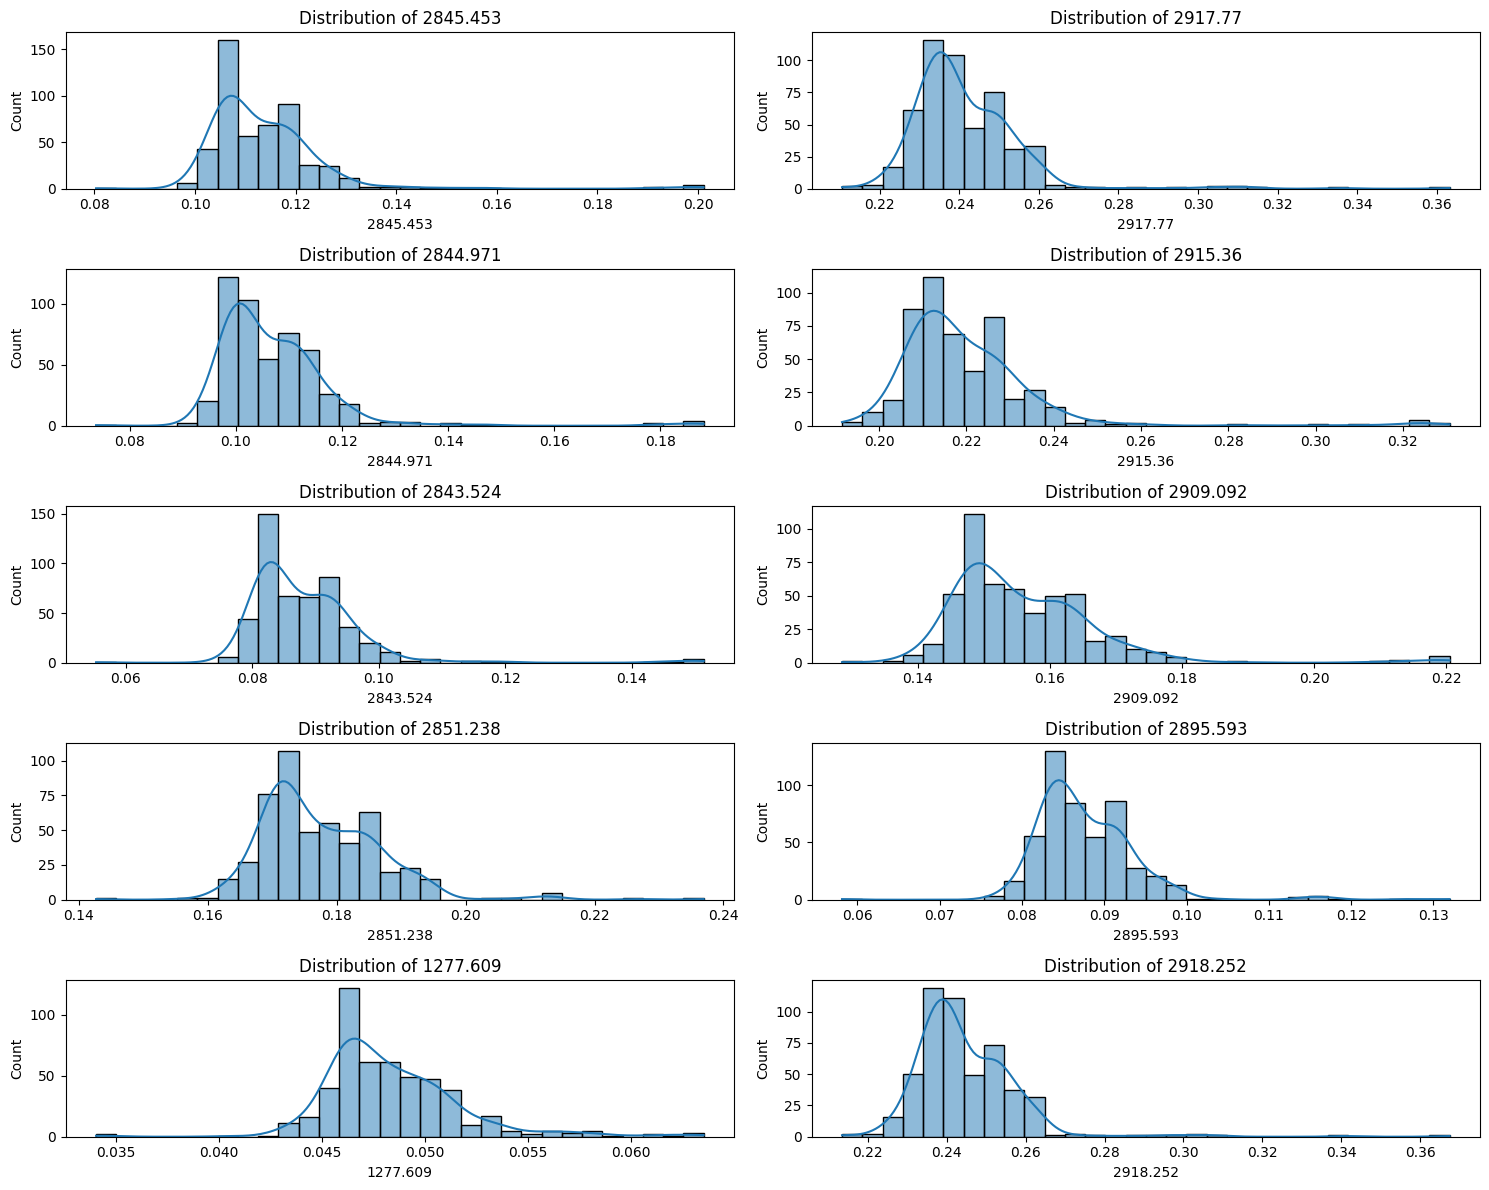

In [8]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()

In [9]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)


Original Data Shape: (503, 6958)
Cleaned Data Shape: (492, 6958)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[numeric_cols_df_0]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.5, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       0.95      0.70      0.81        80
        Thai       0.87      0.98      0.92       166

    accuracy                           0.89       246
   macro avg       0.91      0.84      0.86       246
weighted avg       0.90      0.89      0.89       246

Confusion Matrix:
 [[ 56  24]
 [  3 163]]
prov_char
BBX    0.454545
CBI    1.000000
CCO    1.000000
CPN    1.000000
JHR    1.000000
KBI    1.000000
KBX    0.181818
KRI    1.000000
KTX    0.913043
NRT    1.000000
NWT    1.000000
PKN    0.875000
PLG    1.000000
PNA    1.000000
PTN    1.000000
RIX    0.777778
RNG    1.000000
SGR    1.000000
SKM    1.000000
SNI    0.967742
SNK    1.000000
SSX    1.000000
STN    1.000000
SUX    0.666667
TRG    0.950000
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_40128\4156967957.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


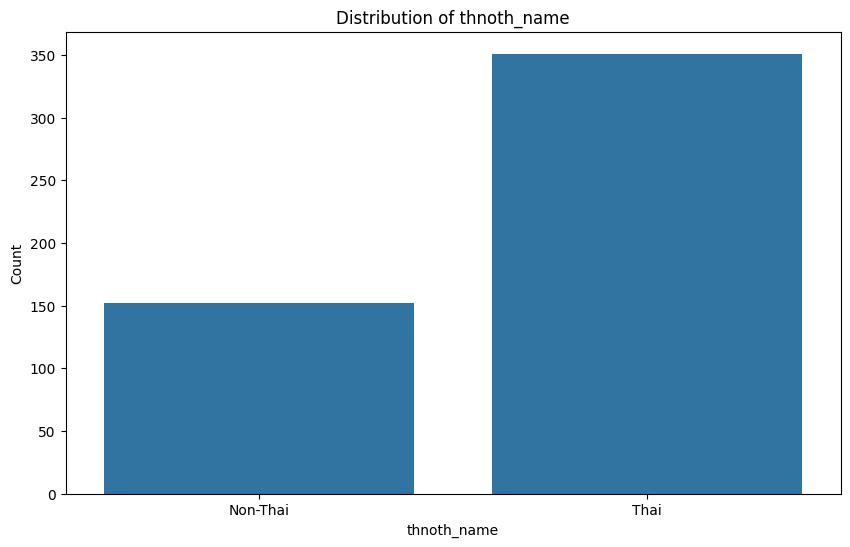

In [11]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [12]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        350
Non-Thai    142
Name: count, dtype: int64


In [13]:
# Separate Thai and Non-Thai samples
df_0_thai = df_0[df_0[target] == 'Thai']
df_0_non_thai = df_0[df_0[target] == 'Non-Thai']

In [14]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_thai[numeric_cols_df_0])
mask = yhat != -1
df_0_thai_cleaned = df_0_thai[mask]

In [15]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_thai_cleaned, df_0_non_thai], axis=0).reset_index(drop=True)

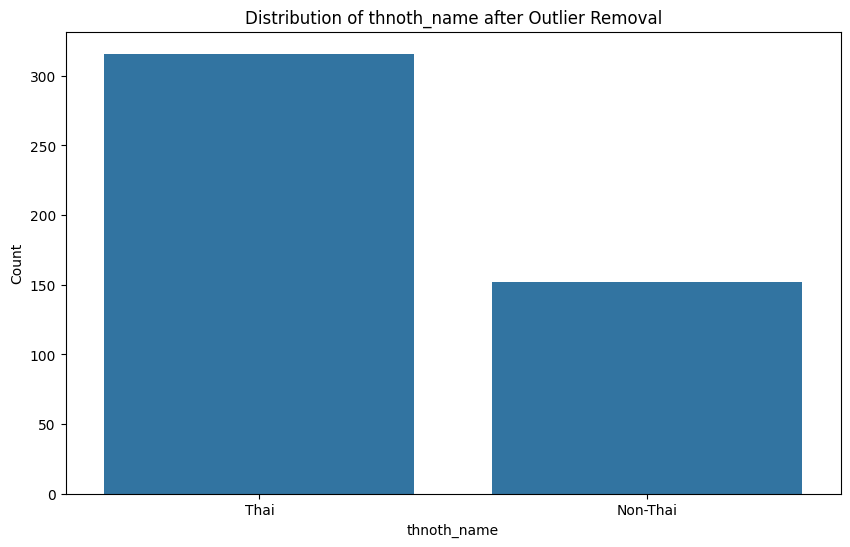

In [16]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [17]:
df_1_cleaned.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new_cleaned.csv", index=False)

In [18]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        316
Non-Thai    152
Name: count, dtype: int64


In [19]:
df_2 = df_1_cleaned.copy()

In [41]:
df_2.drop(columns=['prov_char_encoded', 'thnoth_name_encoded', 'predictions'], inplace=True) 

In [43]:
# Encode 'thnoth_name' column
le_thnoth = LabelEncoder()
df_2['thnoth_name_encoded'] = le_thnoth.fit_transform(df_2['thnoth_name'])

# Encode 'prov_char' column for grouping
le_prov = LabelEncoder()
df_2['prov_char_encoded'] = le_prov.fit_transform(df_2['prov_char'])

# Define the features and target
numeric_cols = df_2.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('thnoth_name_encoded')

X = df_2[numeric_cols]
y = df_2['thnoth_name_encoded']

# Get the numeric values for 'Thai' and 'Non-Thai'
thai_label = le_thnoth.transform(['Thai'])[0]
non_thai_label = le_thnoth.transform(['Non-Thai'])[0]

# Initial RandomForest model to make predictions
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
df_2['predictions'] = rf.predict(X)

Section 2: Filter Out 'TH' Samples and Identify Samples to Be Preserved

In [45]:
# Ensure at least 125 samples per class
min_samples_per_class = 125

# Filter out samples with 'country_char' value 'TH' and make initial predictions
th_samples = df_2[df_2['thnoth_name'] == 'Thai'].copy()
th_samples['predictions'] = rf.predict(th_samples[numeric_cols])

non_thai_samples = df_2[df_2['thnoth_name'] == 'Non-Thai'].copy()
non_thai_samples['predictions'] = rf.predict(non_thai_samples[numeric_cols])


Section 3: Identify and Keep the Most Consistent Thai Samples

In [46]:
# Identify and keep the most consistent Thai samples
consistent_th_samples = th_samples[th_samples['thnoth_name_encoded'] == th_samples['predictions']]

# Ensure at least 125 samples per class
if len(consistent_th_samples) < min_samples_per_class:
    additional_th_samples = th_samples.loc[~th_samples.index.isin(consistent_th_samples.index)]
    additional_samples_needed = min_samples_per_class - len(consistent_th_samples)
    consistent_th_samples = pd.concat([consistent_th_samples, additional_th_samples.sample(n=additional_samples_needed, random_state=42)])


Section 4: Identify and Keep the Most Consistent Non-Thai Samples

In [47]:
# Identify and keep the most consistent Non-Thai samples
consistent_non_thai_samples = non_thai_samples[non_thai_samples['thnoth_name_encoded'] == non_thai_samples['predictions']]

# Ensure at least 125 samples per class
if len(consistent_non_thai_samples) < min_samples_per_class:
    additional_non_thai_samples = non_thai_samples.loc[~non_thai_samples.index.isin(consistent_non_thai_samples.index)]
    additional_samples_needed = min_samples_per_class - len(consistent_non_thai_samples)
    consistent_non_thai_samples = pd.concat([consistent_non_thai_samples, additional_non_thai_samples.sample(n=additional_samples_needed, random_state=42)])


Section 5: Ensure At Least One Sample Per Prov_char is Preserved

In [52]:
# Ensure at least one sample per prov_char is preserved and combine them
preserved_sample_indices = set()
for prov in df_2['prov_char'].unique():
    prov_samples = consistent_th_samples[consistent_th_samples['prov_char'] == prov]
    if not prov_samples.empty:
        preserved_sample_indices.add(prov_samples.sample(n=1, random_state=42).index[0])
    prov_samples = consistent_non_thai_samples[consistent_non_thai_samples['prov_char'] == prov]
    if not prov_samples.empty:
        preserved_sample_indices.add(prov_samples.sample(n=1, random_state=42).index[0])

consistent_th_samples = consistent_th_samples.loc[list(preserved_sample_indices & set(consistent_th_samples.index))]
consistent_non_thai_samples = consistent_non_thai_samples.loc[list(preserved_sample_indices & set(consistent_non_thai_samples.index))]


Section 6: Combine the Consistent Samples

In [53]:
# Combine the consistent samples
df_2_final = pd.concat([consistent_th_samples, consistent_non_thai_samples])

# Final check to ensure each class has at least 125 samples
if len(df_2_final[df_2_final['thnoth_name'] == 'Thai']) < min_samples_per_class:
    additional_th_samples = df_2.loc[df_2['thnoth_name'] == 'Thai'].sample(n=(min_samples_per_class - len(df_2_final[df_2_final['thnoth_name'] == 'Thai'])), random_state=42)
    df_2_final = pd.concat([df_2_final, additional_th_samples])

if len(df_2_final[df_2_final['thnoth_name'] == 'Non-Thai']) < min_samples_per_class:
    additional_non_thai_samples = df_2.loc[df_2['thnoth_name'] == 'Non-Thai'].sample(n=(min_samples_per_class - len(df_2_final[df_2_final['thnoth_name'] == 'Non-Thai'])), random_state=42)
    df_2_final = pd.concat([df_2_final, additional_non_thai_samples])

# Print the number of remaining samples
print("Number of samples removed:", len(df_2) - len(df_2_final))
print("Number of Thai samples:", len(df_2_final[df_2_final['thnoth_name'] == 'Thai']))
print("Number of Non-Thai samples:", len(df_2_final[df_2_final['thnoth_name'] == 'Non-Thai']))


Number of samples removed: 218
Number of Thai samples: 125
Number of Non-Thai samples: 125


Section 7: Proceed with Model Training and Evaluation

c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `

Mean Accuracy: 0.7336731405849052
Mean Precision: 0.96
Mean Recall: 0.7336731405849052
Mean F1-score: 0.797764444527116
Left out group: ['BBX'], Accuracy: 0.0
Left out group: ['CBI'], Accuracy: 1.0
Left out group: ['CCO'], Accuracy: 1.0
Left out group: ['CPN'], Accuracy: 0.7777777777777778
Left out group: ['JHR'], Accuracy: 1.0
Left out group: ['KBI'], Accuracy: 0.9375
Left out group: ['KBX'], Accuracy: 0.11764705882352941
Left out group: ['KRI'], Accuracy: 1.0
Left out group: ['KTX'], Accuracy: 0.5714285714285714
Left out group: ['NRT'], Accuracy: 1.0
Left out group: ['NWT'], Accuracy: 1.0
Left out group: ['PKN'], Accuracy: 0.8333333333333334
Left out group: ['PLG'], Accuracy: 1.0
Left out group: ['PNA'], Accuracy: 1.0
Left out group: ['PTN'], Accuracy: 1.0
Left out group: ['RIX'], Accuracy: 0.4117647058823529
Left out group: ['RNG'], Accuracy: 0.8333333333333334
Left out group: ['SGR'], Accuracy: 0.6363636363636364
Left out group: ['SKM'], Accuracy: 0.25
Left out group: ['SNI'], Accu

c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


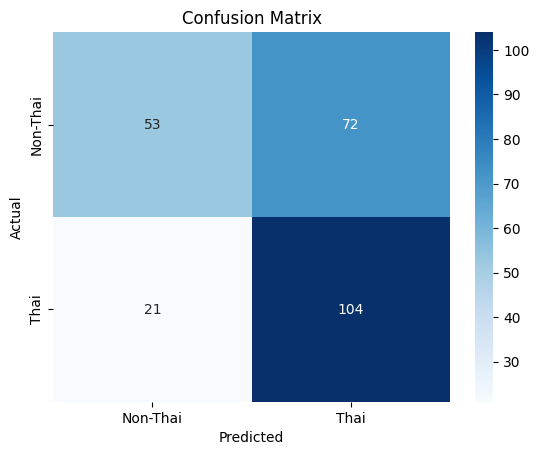

In [54]:
# Define features and target for the balanced dataset
X_balanced = df_2_final[numeric_cols]
y_balanced = df_2_final['thnoth_name_encoded']

# Perform model training and evaluation with balanced dataset
logo = LeaveOneGroupOut()
prov_char_encoded = le_prov.fit_transform(df_2_final['prov_char'])

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Arrays to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    left_out_groups.append(df_2_final['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean scores
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-score: {mean_f1}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_thnoth.classes_, yticklabels=le_thnoth.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


KESIMPULAN: Ini pakai reducing no. of samples based on similarity, not better